In [4]:
import tensorflow as tf 
import os
import scipy.io as sio
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras import utils
from sklearn.metrics import classification_report, confusion_matrix
# itertools内置库
import itertools
import spectral
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# height = y.shape[0]
# width = y.shape[1]
# PATCH_SIZE = 19

In [12]:
path_y_train = r"E:\Eric_HSI\excise2\np_data\y_train" + ".npy"
path_y_val = r"E:\Eric_HSI\excise2\np_data\y_val" + ".npy"

In [13]:
y_train = np.load(path_y_train)
y_val = np.load(path_y_val)
# y_val = utils.to_categorical(y_val)

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), input_shape=(200, 19, 19, 1), strides=(5, 1, 1), activation='relu'),  # 17
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.MaxPooling3D(pool_size=2),  # 8

    tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(16, activation='softmax')]
)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 40, 17, 17, 32)    896       
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 17, 17, 32)    128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 40, 17, 17, 32)    27680     
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 17, 17, 32)    128       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 38, 15, 15, 64)    55360     
_________________________________________________________________
batch_normalization_2 (Batch (None, 38, 15, 15, 64)    256       
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 36, 13, 13, 64)    1

In [16]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau('val_loss', patience=3, factor=0.5, min_lr=0.00001)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'])

In [17]:
model.load_weights(r'E:\Eric_HSI\excise2\weights\model_weight.ckpt')

In [29]:
target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
           ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
            'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
           'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
           'Stone-Steel-Towers']
def reports(X_test,y_test):
    Y_pred = model.predict(X_test)  #   是一个(5125, 16)的 ndarray 的概率值
    # 概率最大的值的位置就为预测的类别
    y_pred = np.argmax(Y_pred, axis=1)

    # 分类报告：precision    recall  f1-score   support
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    # 混淆矩阵
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    # 模型得分
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss = score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy

In [30]:
# calculate result, loss, accuray and confusion matrix
classification, confusion, Test_loss, Test_accuracy = reports(y_train, y_val)
classification = str(classification)
confusion_str = str(confusion)

# show result and save to file
# print('Test loss {} (%)'.format(Test_loss))
# print('Test accuracy {} (%)'.format(Test_accuracy))
# print("classification result: ")
# print('{}'.format(classification))
# print("confusion matrix: ")
# print('{}'.format(confusion_str))

result = r'E:\Eric_HSI\excise2\result'
if not os.path.exists(result):
    os.mkdir(result)

file_name = './result/report' + ".txt"
with open(file_name, 'w') as x_file:
    x_file.write('Test loss {} (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('Test accuracy {} (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write(" classification result: \n")
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write(" confusion matrix: \n")
    x_file.write('{}'.format(confusion_str))

257/257 [==============================] - 10s 37ms/step - loss: 0.0371 - acc: 0.9915


In [33]:
# 进行最后绘图
# 此函数接受混淆矩阵
# 并判断是否将混淆矩阵标准化输出
def plot_confusion_matrix(confusion, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.get_cmap("Blues")):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Normalization 的意思是将整个数据变为 0-1 之间
    """
    Normalized = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
    if normalize:
        confusion = Normalized
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    # 显示混淆矩阵
    print(confusion)

    plt.imshow(Normalized, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.title(title)

    # 设置x，y轴的标签为自定义的
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # 如果将confusion 标准化与否的输出形式
    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(confusion.shape[0]), range(confusion.shape[1])):
        thresh = confusion[i].max() / 2.
        # 画图时给图中的点加标签之 plt.text，
        plt.text(j, i, format(confusion[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if confusion[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  39    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0 1122    1    0    0    0    0    0    0    3    7    1    0    0
     0    0]
 [   0    0  680    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0  192    0    0    0    0    0    0    0    2    0    0
     0    0]
 [   0    0    0    0  382    0    0    0    0    5    0    0    0    0
     0    0]
 [   0    0    0    0    0  560    0    0    0    0    2    0    0    1
     0    0]
 [   0    0    0    0    0    0   20    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  381    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   17    0    0    0    0    0
     0    0]
 [   0    4    0    0    0    0    0    0    0  774    0    1    0    0
     0    0]
 [   0   20    0    0    0    1    0    0    0    2 1963    0    0    0
     0    0]
 [   0    2    0    0    

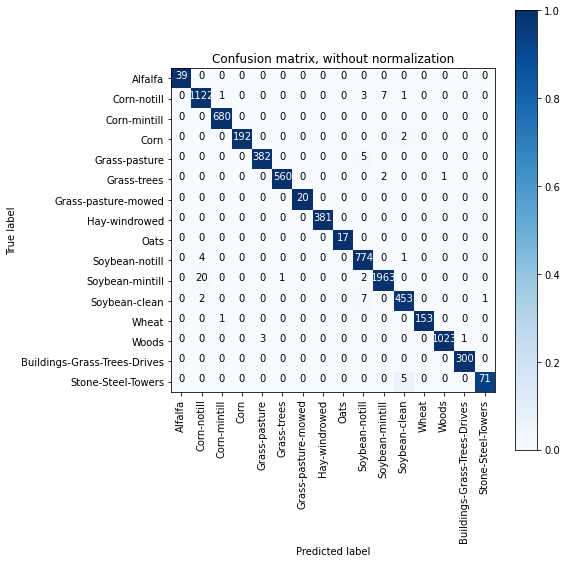

In [34]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion, classes=target_names, normalize=False, 
                      title='Confusion matrix, without normalization')
# SVG它的英文全称为Scalable Vector Graphics，意思为可缩放的矢量图形
plt.savefig("./result/confusion_matrix_without_normalization.svg")
# plt.show()

In [19]:
def loadIndianPinesData():
    data_path = 'E:\Eric_HSI\hyperspectral_datasets'
    data = sio.loadmat(os.path.join(data_path, 
                      'Indian_pines_corrected.mat'))['data']
    labels = sio.loadmat(os.path.join(data_path, 
                        'Indian_pines_gt.mat'))['groundT']
    
    return data, labels

# slice(start, stop[, step]) 函数实现切片对象，主要用在切片操作函数里的参数传递。
def Patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+PATCH_SIZE)    # 0 - 126   19 - 145
    width_slice = slice(width_index, width_index+PATCH_SIZE)       # 0 - 126   19 - 145
    patch = data[height_slice, width_slice, :]                     #  19 * 19 * 200
    
    return patch

In [20]:
# load the original image
X, y = loadIndianPinesData()
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = 19

In [21]:
# calculate the predicted image
# 因为经过 padding 和 patch 操作，预测过程有一点曲折
outputs = np.zeros((height,width))
for i in range(height-PATCH_SIZE+1):            # 0 - 126
    for j in range(width-PATCH_SIZE+1):        # 0 - 126
        # print(i)
        # print(j)
        p = int(PATCH_SIZE/2)          # 9
        target = y[i+p][j+p]             # y[9-135]
        if target == 0:
            continue
        else:
            image_patch=Patch(X,i,j)   # 创建 patch 的逆操作，切片
            # print (image_patch.shape)   # 19*19*200
            X_test_image = image_patch.reshape(1,image_patch.shape[2],image_patch.shape[0],image_patch.shape[1], 1).astype('float32')  # 1*200*19*19*1
            prediction = np.argmax(model.predict(X_test_image), axis=-1)
            print(prediction)
            outputs[i+p][j+p] = prediction+1              # 126+9 = 135

[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15]


KeyboardInterrupt: 

In [65]:
# slice 的用法
# height_slice = slice(3, 6)    # 0 - 126   19 - 145
# print(height_slice)

# X = np.arange(10)
# print(X)
# X[height_slice]

slice(3, 6, None)


In [ ]:
predict_image = spectral.imshow(classes=outputs.astype(int), figsize=(6, 6))

In [48]:
X_test_image.shape

(1, 200, 19, 19, 1)

In [47]:
model.predict(X_test_image)
# np.argmax(model.predict(X_test_image), axis=-1)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
      dtype=float32)

In [39]:
path_x_train = r"E:\Eric_HSI\excise2\np_data\x_train" + ".npy"
x_train = np.load(path_x_train)

In [43]:
prediction = np.argmax(model.predict(x_train), axis=-1)
prediction

array([ 5,  9,  2, ..., 14,  5, 13], dtype=int64)

In [45]:
len(prediction)

2049

In [40]:
x_train.shape

(2049, 200, 19, 19, 1)

In [55]:
np.argmax([1,2,3], axis=-1)

2